In [1]:
# import the necessary packages
import numpy as np
import cv2
from matplotlib import pyplot as plt
import imutils

In [2]:
from os import listdir
from os.path import isfile, join
images_paths = sorted([f for f in listdir('../images') if isfile(join('../images', f))])

In [59]:
def bound_box(image_path):
    # load the image and convert it to grayscale
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    """print(image.shape)
    plt.imshow(gray, 'gray')"""

    # Find contours
    kernel_horizontal_derivative = 1/4 * np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
    image_horizontal_derivative = cv2.filter2D(gray, -1, kernel_horizontal_derivative)
    image_horizontal_derivative = np.abs(image_horizontal_derivative)
    kernel_vertical_derivative = 1/4 * np.array([[-1,-2,-1], [0,0,0], [1,2,1]])
    image_vertical_derivative = cv2.filter2D(gray, -1, kernel_vertical_derivative)
    image_vertical_derivative = np.abs(image_vertical_derivative)

    image_derivative = np.maximum(image_horizontal_derivative, image_vertical_derivative)

    """plt.figure()
    plt.imshow(image_horizontal_derivative, 'gray')"""
    
    ret2,thresh = cv2.threshold(image_horizontal_derivative,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (20, 20))
    closed0 = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 100))
    opened = cv2.morphologyEx(closed0, cv2.MORPH_OPEN, kernel)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 1))
    opened1 = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)
    
    kernel = np.zeros((11,11),np.uint8)
    kernel[5,:] = 1
    dilated = cv2.dilate(opened1, kernel, iterations = 5)
    
    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #print(cnts)
    cnts = imutils.grab_contours(cnts)
    c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
    # compute the rotated bounding box of the largest contour
    rect = cv2.minAreaRect(c)
    #print(rect)
    box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
    box = np.int0(box)
    #print(box)
    # draw a bounding box arounded the detected barcode and display the
    # image
    image_bb = image.copy()
    cv2.drawContours(image_bb, [box], -1, (0, 255, 0), 3)
    plt.figure()
    plt.imshow(image_bb, 'gray')
    
    coordinates_source = box.astype('float32')
    min_width = coordinates_source[:,0].min()
    min_height = coordinates_source[:,1].min()
    max_width = coordinates_source[:,0].max()
    max_height = coordinates_source[:,1].max()
    def normalize(value, axis=0):
        if axis==0:  # Horizontal dimension
            return min_width if (value-min_width<max_width-value) \
                             else max_width
        elif axis==1:  # Vertical dimension
            return min_height if (value-min_height<max_height-value) \
                              else max_height
    coordinates_source = np.array(sorted([tuple(v) for v in coordinates_source], key=lambda t: (normalize(t[1], axis=1),
                                                                                                normalize(t[0], axis=0))))
    print(coordinates_source)
    def dist(point1, point2):
        return np.sqrt(np.sum((point1-point2)**2))
    destination_height = int(max([dist(coordinates_source[0],coordinates_source[2]),
                             dist(coordinates_source[1],coordinates_source[3])]))
    destination_width = int(max([dist(coordinates_source[0],coordinates_source[1]),
                             dist(coordinates_source[2],coordinates_source[3])]))
    coordinates_destination = np.array([[0, 0],
                                        [destination_width-1, 0],
                                        [0, destination_height-1],
                                        [destination_width-1, destination_height-1]], dtype='float32')
    # Computing the trasformation, i.e. homography. Warping.
    H = cv2.getPerspectiveTransform(coordinates_source, coordinates_destination)
    # Applying the trasformation
    gray1 = cv2.warpPerspective(gray, H, (destination_width, destination_height))
    plt.figure()
    plt.imshow(gray1, 'gray')

[[ 405.  260.]
 [1301.  258.]
 [ 407. 1052.]
 [1303. 1049.]]
Wall time: 303 ms


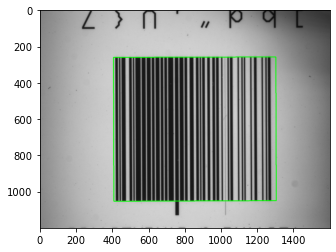

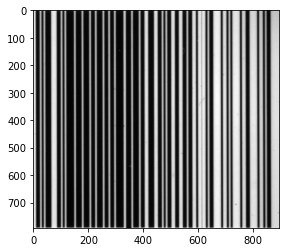

In [4]:
%%time
bound_box(f'../images/{images_paths[0]}')

[[ 353.  288.]
 [1253.  288.]
 [ 353. 1084.]
 [1253. 1084.]]
Wall time: 369 ms


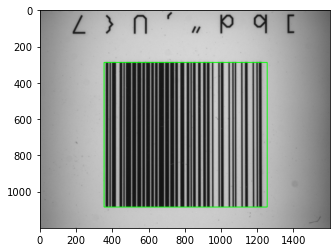

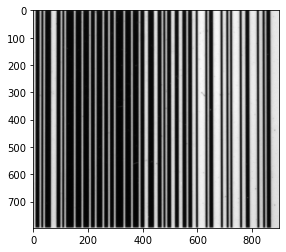

In [5]:
%%time
bound_box(f'../images/{images_paths[1]}')

[[ 202.  242.]
 [1048.  237.]
 [ 205.  723.]
 [1051.  718.]]
Wall time: 226 ms


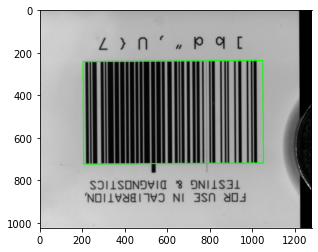

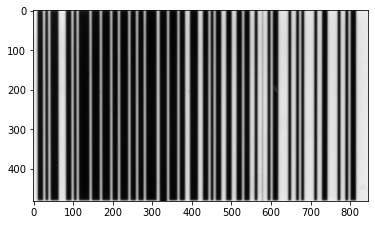

In [6]:
%%time
bound_box(f'../images/{images_paths[2]}')

[[132. 258.]
 [978. 258.]
 [132. 740.]
 [978. 740.]]
Wall time: 213 ms


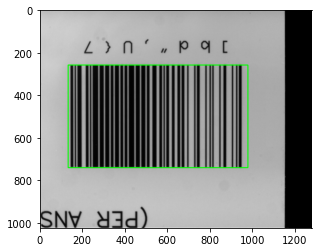

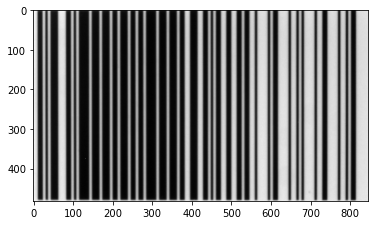

In [7]:
%%time
bound_box(f'../images/{images_paths[3]}')

[[330. 172.]
 [910. 172.]
 [330. 685.]
 [910. 685.]]
Wall time: 254 ms


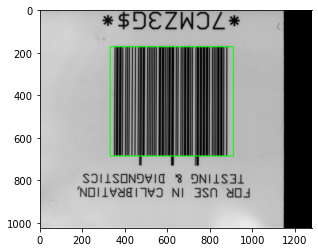

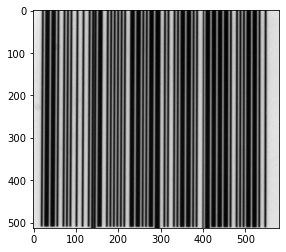

In [8]:
%%time
bound_box(f'../images/{images_paths[4]}')

[[336. 251.]
 [919. 251.]
 [336. 763.]
 [919. 763.]]


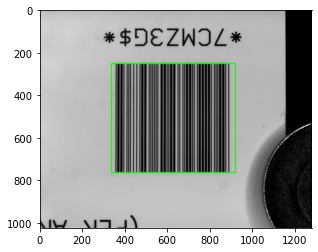

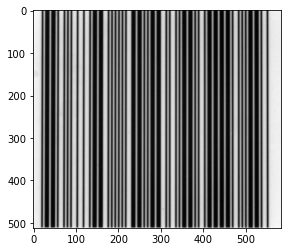

In [9]:
bound_box(f'../images/{images_paths[5]}')

[[ 162.  286.]
 [1108.  286.]
 [ 162.  799.]
 [1108.  799.]]


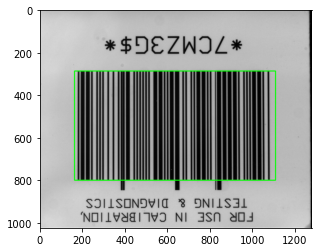

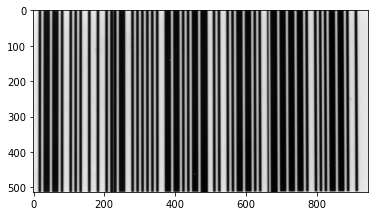

In [10]:
bound_box(f'../images/{images_paths[6]}')

[[ 147.  274.]
 [1099.  276.]
 [ 146.  787.]
 [1098.  789.]]


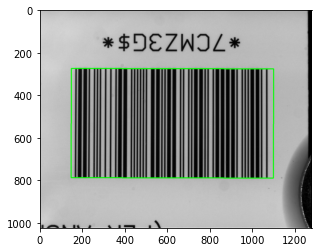

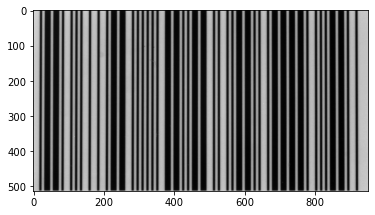

In [11]:
bound_box(f'../images/{images_paths[7]}')

[[327. 335.]
 [982. 340.]
 [323. 778.]
 [978. 784.]]


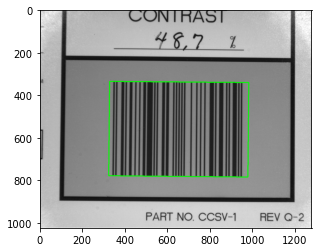

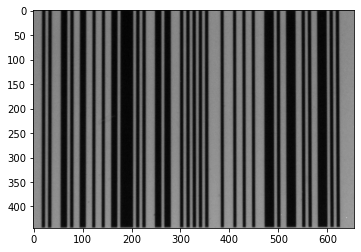

In [12]:
bound_box(f'../images/{images_paths[8]}')

[[339. 278.]
 [988. 287.]
 [333. 719.]
 [982. 728.]]


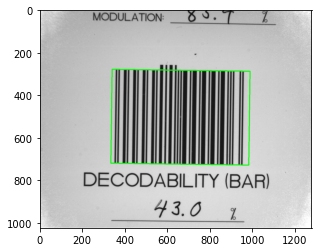

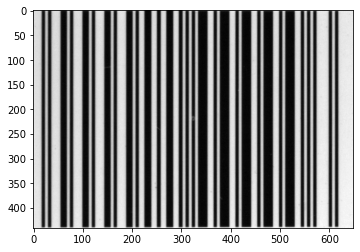

In [13]:
bound_box(f'../images/{images_paths[9]}')

In [14]:
print(f'../images/{images_paths[10]}')

images/EAN-UPC-DEFECTS IMGB.BMP


In [15]:
#bound_box(f'../images/{images_paths[10]}')

[[263. 308.]
 [962. 305.]
 [265. 756.]
 [964. 753.]]


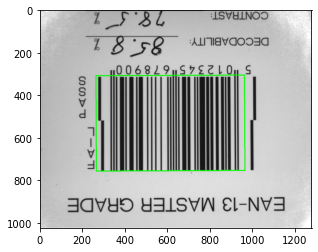

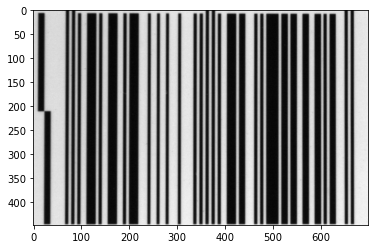

In [60]:
bound_box(f'../images/{images_paths[11]}')

In [17]:
#bound_box(f'../images/{images_paths[12]}')

[[ 101.  118.]
 [1303.  120.]
 [ 100.  310.]
 [1302.  312.]]


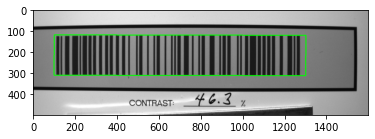

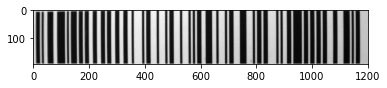

In [18]:
bound_box(f'../images/{images_paths[13]}')

[[ 165.  146.]
 [1360.  146.]
 [ 165.  336.]
 [1360.  336.]]


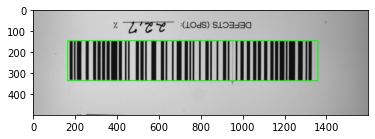

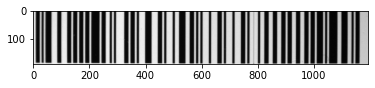

In [19]:
bound_box(f'../images/{images_paths[14]}')

[[ 180.  167.]
 [1393.  156.]
 [ 182.  360.]
 [1395.  349.]]


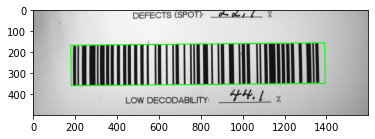

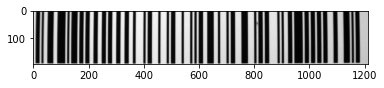

In [20]:
bound_box(f'../images/{images_paths[15]}')

[[ 203.  141.]
 [1400.  141.]
 [ 203.  331.]
 [1400.  331.]]


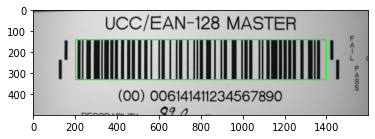

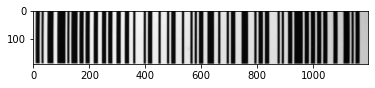

In [21]:
bound_box(f'../images/{images_paths[16]}')

[[ 194.  146.]
 [1360.  127.]
 [ 198.  384.]
 [1364.  365.]]


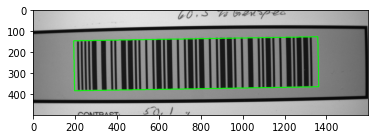

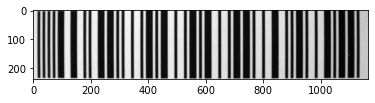

In [61]:
bound_box(f'../images/{images_paths[17]}')

[[ 196.  129.]
 [1366.  118.]
 [ 198.  369.]
 [1368.  358.]]


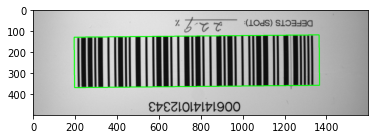

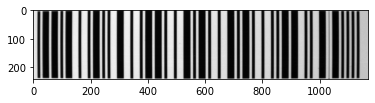

In [23]:
bound_box(f'../images/{images_paths[18]}')

[[ 229.   60.]
 [1394.   60.]
 [ 229.  297.]
 [1394.  297.]]


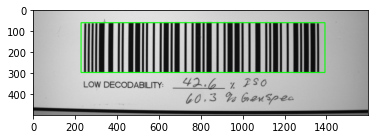

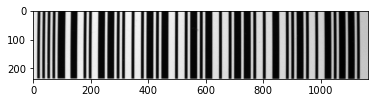

In [24]:
bound_box(f'../images/{images_paths[19]}')

[[ 247.  141.]
 [1416.  132.]
 [ 248.  380.]
 [1418.  372.]]


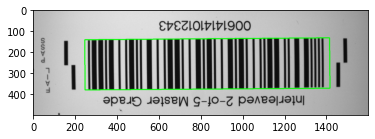

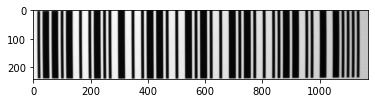

In [25]:
bound_box(f'../images/{images_paths[20]}')

In [26]:
print(f'../images/{images_paths[21]}')

images/TestChart.xls


In [27]:
#bound_box(f'../images/{images_paths[21]}')

[[191. 241.]
 [885. 236.]
 [194. 642.]
 [888. 637.]]


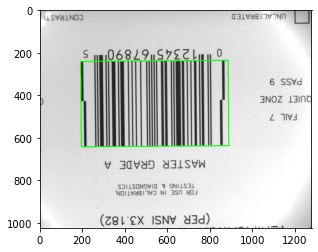

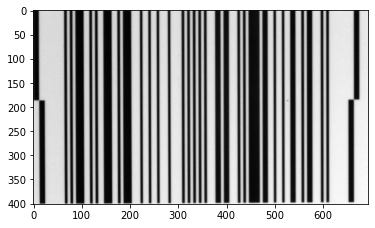

In [28]:
bound_box(f'../images/{images_paths[22]}')

[[309. 335.]
 [904. 339.]
 [306. 735.]
 [901. 739.]]


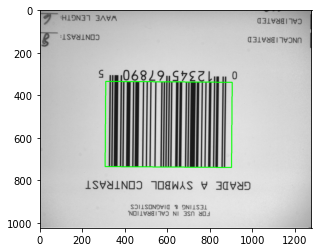

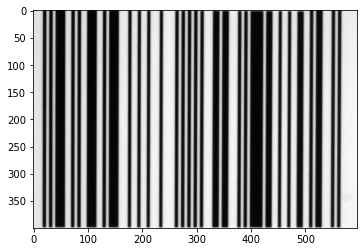

In [29]:
bound_box(f'../images/{images_paths[23]}')

[[342. 330.]
 [936. 340.]
 [336. 731.]
 [929. 740.]]


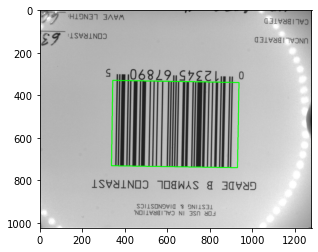

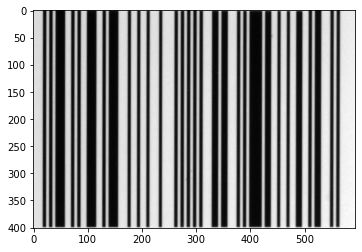

In [30]:
bound_box(f'../images/{images_paths[24]}')

[[350. 335.]
 [944. 335.]
 [350. 734.]
 [944. 734.]]


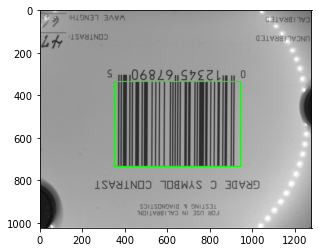

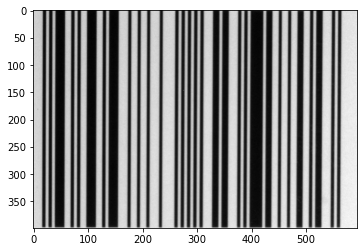

In [31]:
bound_box(f'../images/{images_paths[25]}')

[[289. 308.]
 [882. 329.]
 [275. 711.]
 [869. 731.]]


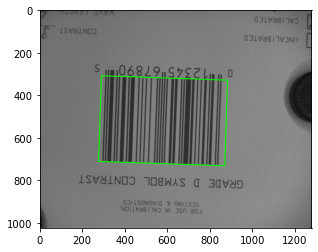

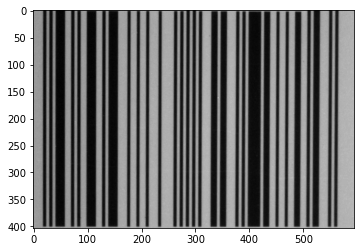

In [32]:
bound_box(f'../images/{images_paths[26]}')

[[326. 320.]
 [920. 330.]
 [320. 721.]
 [913. 730.]]


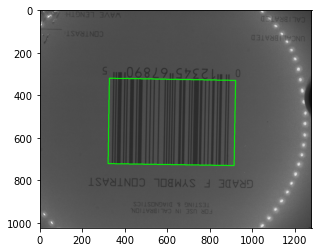

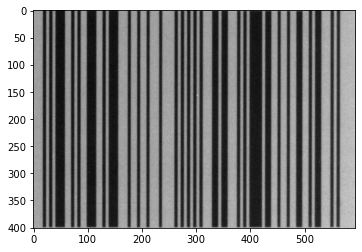

In [33]:
bound_box(f'../images/{images_paths[27]}')

[[321. 324.]
 [916. 331.]
 [316. 726.]
 [911. 733.]]


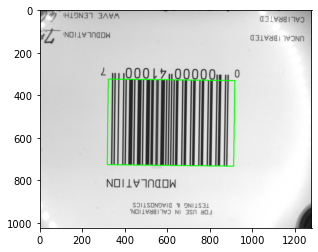

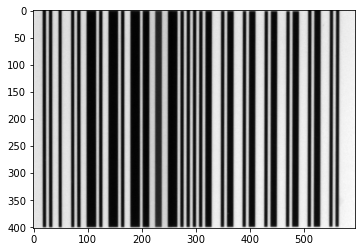

In [34]:
bound_box(f'../images/{images_paths[28]}')

[[320. 330.]
 [915. 339.]
 [314. 731.]
 [909. 741.]]


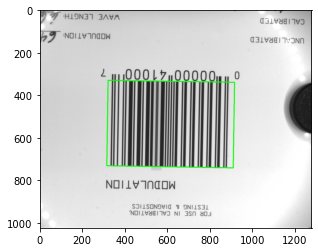

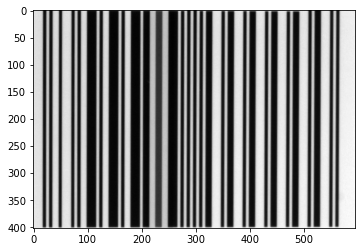

In [35]:
bound_box(f'../images/{images_paths[29]}')

[[317. 340.]
 [913. 351.]
 [310. 742.]
 [906. 752.]]


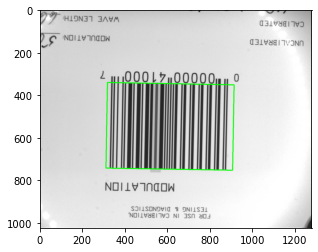

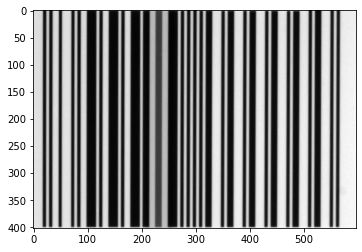

In [36]:
bound_box(f'../images/{images_paths[30]}')

[[325. 329.]
 [919. 345.]
 [314. 730.]
 [908. 746.]]


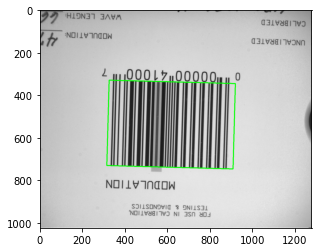

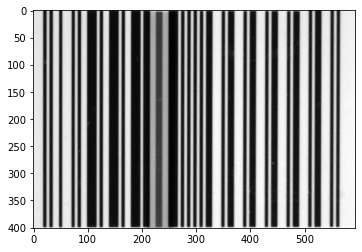

In [37]:
bound_box(f'../images/{images_paths[31]}')

[[328. 321.]
 [922. 321.]
 [328. 722.]
 [922. 722.]]


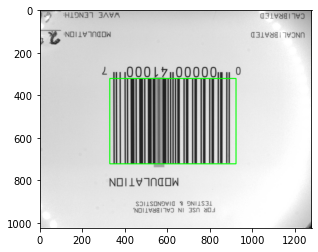

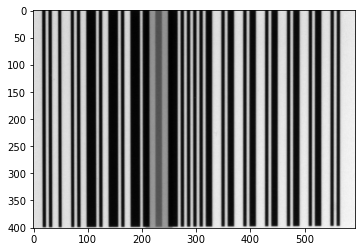

In [38]:
bound_box(f'../images/{images_paths[32]}')

[[339. 327.]
 [933. 332.]
 [336. 729.]
 [930. 733.]]


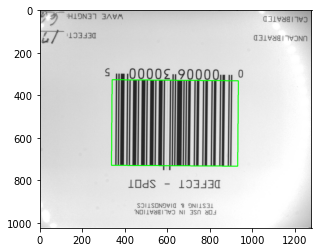

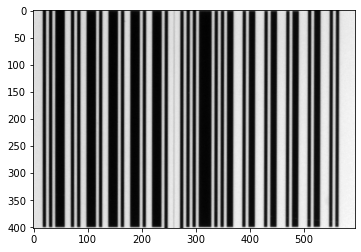

In [39]:
bound_box(f'../images/{images_paths[34]}')

[[338. 318.]
 [933. 325.]
 [333. 719.]
 [928. 726.]]


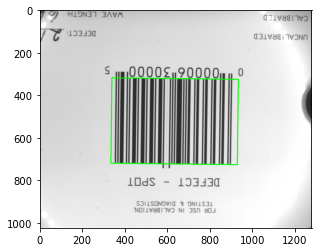

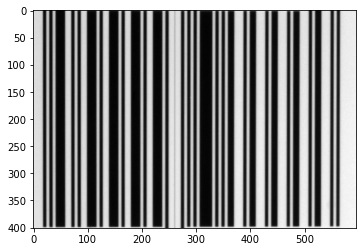

In [40]:
bound_box(f'../images/{images_paths[35]}')

[[326. 322.]
 [919. 323.]
 [326. 722.]
 [919. 722.]]


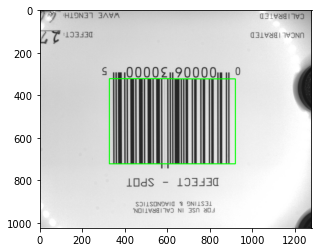

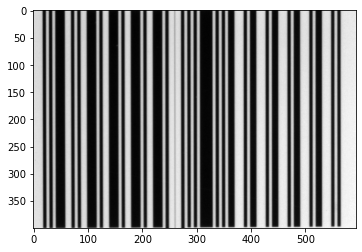

In [41]:
bound_box(f'../images/{images_paths[36]}')

[[314. 329.]
 [908. 329.]
 [314. 729.]
 [908. 729.]]


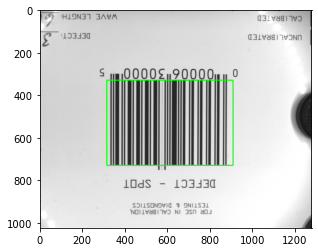

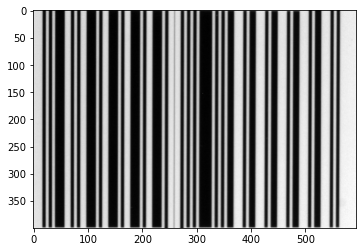

In [42]:
bound_box(f'../images/{images_paths[37]}')

[[325. 330.]
 [921. 330.]
 [325. 731.]
 [921. 731.]]


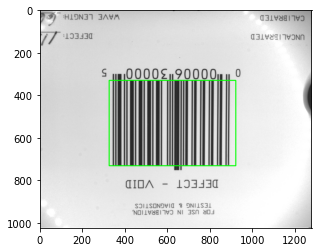

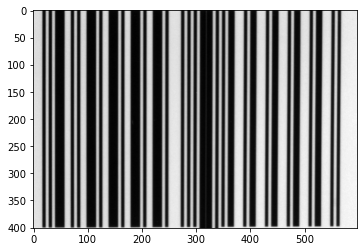

In [43]:
bound_box(f'../images/{images_paths[38]}')

[[328. 322.]
 [924. 326.]
 [325. 723.]
 [921. 728.]]


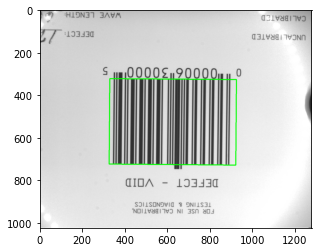

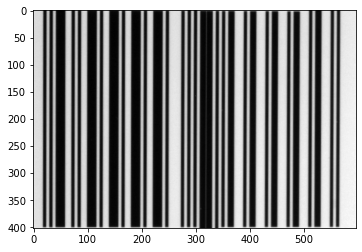

In [44]:
bound_box(f'../images/{images_paths[39]}')

[[293. 332.]
 [888. 334.]
 [292. 732.]
 [887. 734.]]


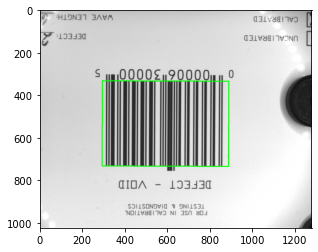

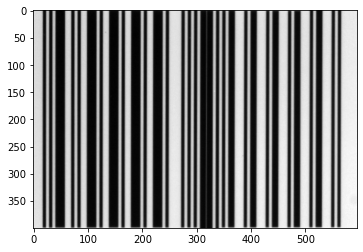

In [45]:
bound_box(f'../images/{images_paths[40]}')

[[283. 324.]
 [879. 322.]
 [284. 725.]
 [880. 723.]]


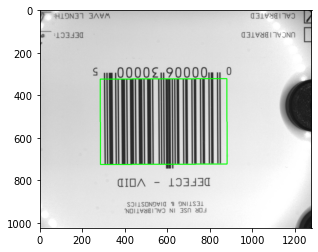

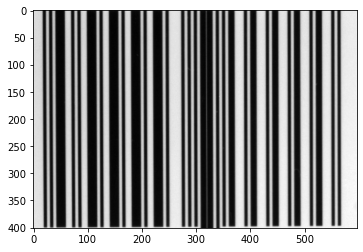

In [46]:
bound_box(f'../images/{images_paths[41]}')

[[281. 322.]
 [876. 322.]
 [281. 722.]
 [876. 722.]]


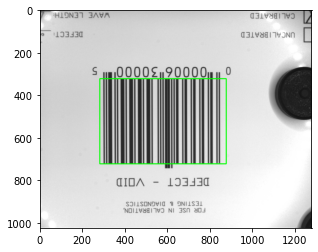

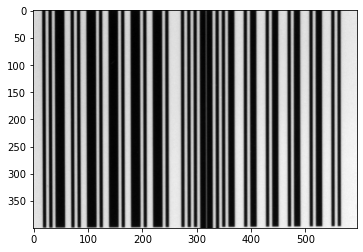

In [47]:
bound_box(f'../images/{images_paths[42]}')

[[275. 317.]
 [870. 317.]
 [275. 718.]
 [870. 718.]]


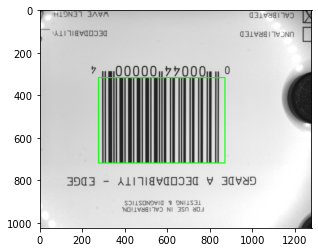

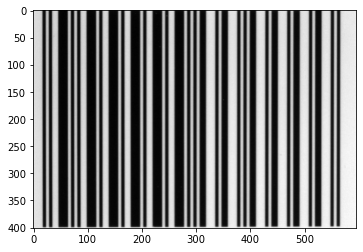

In [48]:
bound_box(f'../images/{images_paths[43]}')

[[284. 323.]
 [880. 325.]
 [283. 724.]
 [878. 727.]]


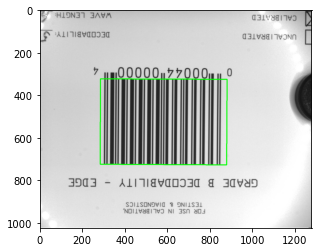

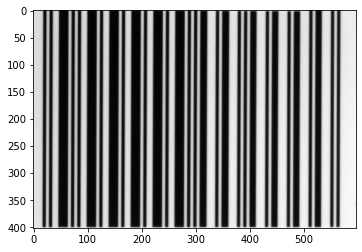

In [49]:
bound_box(f'../images/{images_paths[44]}')

[[274. 335.]
 [869. 337.]
 [272. 736.]
 [867. 739.]]


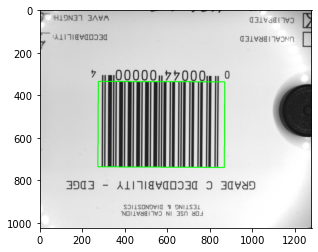

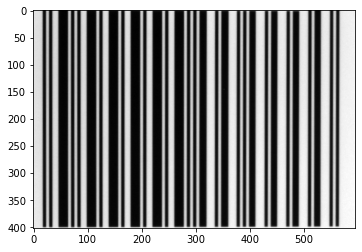

In [50]:
bound_box(f'../images/{images_paths[45]}')

[[258. 323.]
 [854. 331.]
 [253. 725.]
 [848. 733.]]


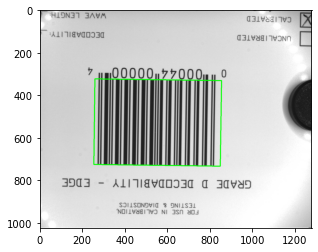

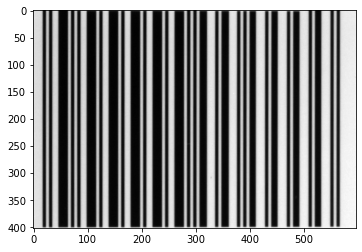

In [51]:
bound_box(f'../images/{images_paths[46]}')

[[252. 332.]
 [848. 336.]
 [249. 733.]
 [845. 738.]]


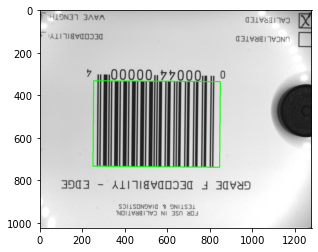

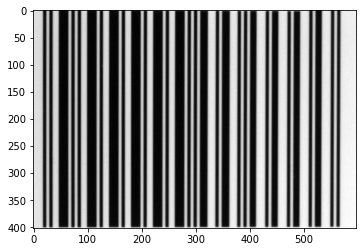

In [52]:
bound_box(f'../images/{images_paths[47]}')

[[246. 330.]
 [842. 337.]
 [241. 732.]
 [838. 739.]]


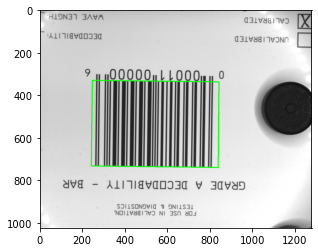

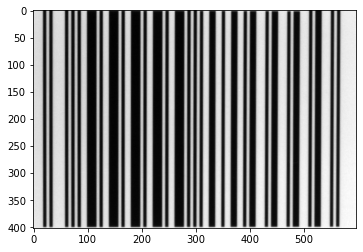

In [53]:
bound_box(f'../images/{images_paths[48]}')

[[250. 331.]
 [847. 337.]
 [245. 733.]
 [842. 740.]]


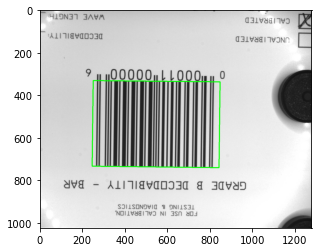

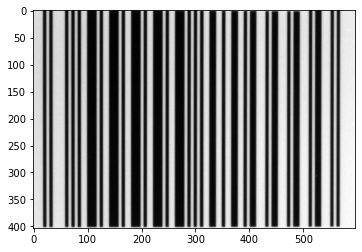

In [54]:
bound_box(f'../images/{images_paths[49]}')

[[274. 309.]
 [870. 315.]
 [270. 710.]
 [866. 717.]]


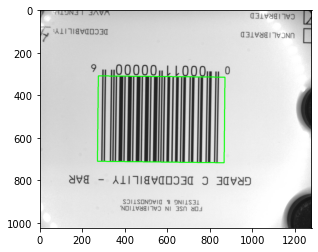

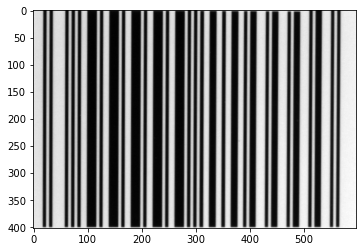

In [55]:
bound_box(f'../images/{images_paths[50]}')

[[277. 318.]
 [873. 326.]
 [271. 720.]
 [868. 728.]]


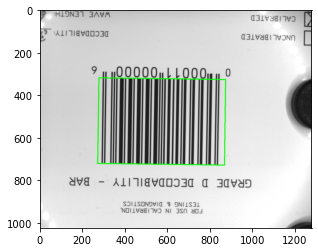

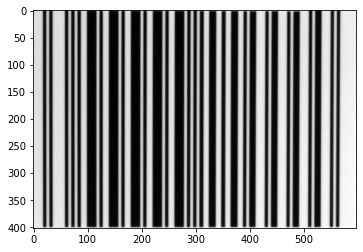

In [56]:
bound_box(f'../images/{images_paths[51]}')

[[291. 322.]
 [886. 322.]
 [291. 723.]
 [886. 723.]]


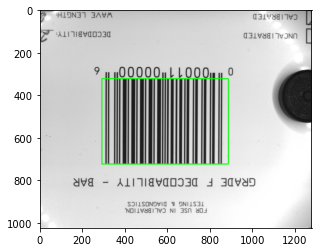

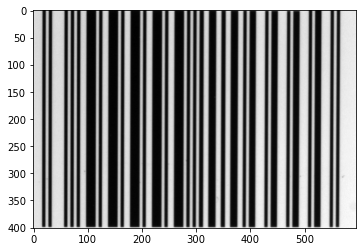

In [57]:
bound_box(f'../images/{images_paths[52]}')

In [58]:
%%time
bound_box('other images/1.png')

IndexError: list index out of range